In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="preprocessing",
    experiment_info={"sample" : "N5CC3E-T1", 
                     "modality" : "scATAC"},
    verbose=True
)
workspace.load_workspace()
print(workspace.experiment_info)
sns.set()

{'modality': 'scATAC', 'sample': 'N5CC3E-T1'}


In [2]:
data = {
    data_type : util.pickle_load(workspace.tmp_data[data_type])
    for data_type in ["snp_counts", "phasing", "blocks"]
}
data["snp"] = data["snp_counts"]\
                [["CHROM", "POS"]]\
                .to_dense()\
                .astype(np.int64)

In [3]:
data["blocks"].columns

Index(['CHROM', 'START', 'END', 'COPY_NUMBER', 'BLOCK_ID'], dtype='object')

In [4]:
chrom_to_blocks = {
    str(chrom) : data["blocks"][data["blocks"]["CHROM"] == chrom]
    for chrom in data["blocks"]["CHROM"].unique()
}

In [5]:
%%time

# Here block coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def intersect_snp_with_blocks(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellSNP is 1-based, but .bed files are 0-based
    blocks_on_chrom = chrom_to_blocks.get(str(chrom), None)
    if blocks_on_chrom is None:
        return ""
    mask = ((blocks_on_chrom.START <= pos) 
            & (pos < blocks_on_chrom.END))
    return '@'.join(blocks_on_chrom[mask].BLOCK_ID)

# result = [intersect_snp_with_blocks(snp_tuple) 
#           for snp_tuple in tqdm_notebook(data["snp"][data["snp"]["CHROM"] == 10].values, 
#                                          "SNP processing")]
pool = mp.Pool(16)
result = pool.map(intersect_snp_with_blocks, 
                  tqdm_notebook(data["snp"].values, 
                                "SNP processing"))
pool.close()
pool.join()


CPU times: user 13.9 s, sys: 1.62 s, total: 15.5 s
Wall time: 2min 28s


In [6]:
""" Here the raw results computed in parallel are parsed """
snp_to_blocks, block_to_snps = {}, OrderedDict()

# This way we ensure proper block ordering
for block_id in data["blocks"].BLOCK_ID:
    block_to_snps[block_id] = []

for i, row in tqdm_notebook(enumerate(data["snp"].values), 
                            "mapping SNPs to blocks"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_blocks[snp] = result[i].split("@") if result[i] else []
    for block in snp_to_blocks[snp]:
        block_to_snps[block].append(snp)

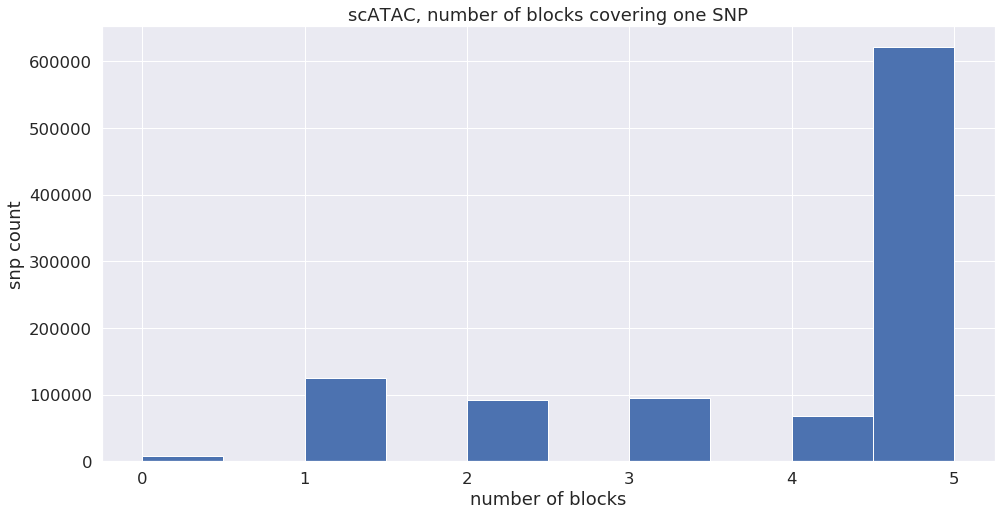

In [7]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title(f"{workspace.experiment_info['modality']}, "
          "number of blocks covering one SNP")
plt.xlabel("number of blocks")
plt.ylabel("snp count")
plt.hist([len(block_list) for block_list in snp_to_blocks.values()]);

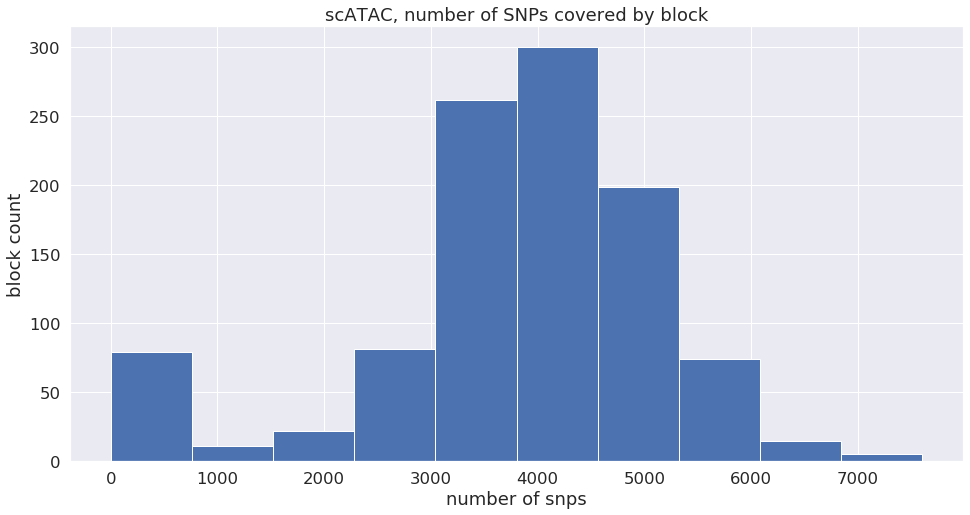

In [8]:
plt.figure(figsize=(16,8))
plt.title(f"{workspace.experiment_info['modality']}"
          ", number of SNPs covered by block")
plt.xlabel("number of snps")
plt.ylabel("block count")
plt.hist([len(snp_list) for snp_list 
          in block_to_snps.values()]);

In [9]:
util.pickle_dump(
    snp_to_blocks, 
    f"{workspace.tmp_dir}/snp_to_blocks.pkl"
)
workspace.add_entry("snp_to_blocks", "10mb_eagle2_snp_to_cn.pkl")
util.pickle_dump(
    block_to_snps, 
    f"{workspace.tmp_dir}/block_to_snps.pkl"
)
workspace.add_entry("block_to_snps", "10mb_eagle2_cn_to_snps.pkl")

In [10]:
workspace.status()

Staged for commit: 
	-snp_to_blocks : 10mb_eagle2_snp_to_cn.pkl
	-block_to_snps : 10mb_eagle2_cn_to_snps.pkl


In [11]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(toolkit.extract_snps(data["snp_counts"])), 
                            "mapping snps to their index numbers "
                            "by position in the blocks")}

In [12]:
%%time

block_to_snp_ids = {block : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for block, snp_list 
                   in tqdm_notebook(block_to_snps.items(), 
                                    desc="mapping block to SNP ids"
                                    " (for faster row selection)")}

import numba
# @numba.jit(nopython=True)
def get_block_counts(ad, dp, snp_ids):
    if snp_ids.size > 0:
#         mask = np.zeros(ad.size).astype(np.bool)
#         mask[snp_ids] = True
#         ad_sample, dp_sample = ad[s], dp[mask]
        return np.nansum(ad[snp_ids]), np.nansum(dp[snp_ids])
    return np.nan, np.nan


def extract_block_counts(barcode):
    block_to_ad, block_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
    ad = np.array(data["snp_counts"][f"{barcode}_ad"])
    dp = np.array(data["snp_counts"][f"{barcode}_dp"])
    
    # block_to_snps is an OrderedDict, so we can guarantee
    # that all the blocks are processed in a correct order
    for snp_ids in block_to_snp_ids.values():
        if len(snp_ids) > 0:
            dp_sum = np.nansum(dp[snp_ids])
            block_to_dp.append(np.nan if dp_sum == 0 else dp_sum)
            block_to_ad.append(np.nan if dp_sum == 0 
                               else np.nansum(ad[snp_ids]))
        else:
            block_to_ad.append(np.nan)
            block_to_dp.append(np.nan)
    
    return pd.SparseDataFrame({
        f"{barcode}_ad" : block_to_ad, 
        f"{barcode}_dp" : block_to_dp
    })


pool = mp.Pool(16)
result_list = pool.map(
    extract_block_counts, 
    tqdm_notebook(toolkit.extract_barcodes(data["snp_counts"]), 
                  desc="cell_barcode processing")
)
pool.close()
pool.join()
# result_list = [extract_block_counts(barcode) for barcode in 
#                tqdm_notebook(toolkit.extract_barcodes(data["snp_counts"]), 
#                              desc="cell_barcode processing")]
data["block_counts"] = pd.concat(result_list, axis=1)
data["block_counts"].info()


<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Columns: 14332 entries, AAACGAAAGGGAGATA-1_ad to TTTGTGTTCTTAATCC-1_dp
dtypes: Sparse[float64, nan](14332)
memory usage: 59.0 MB
CPU times: user 20.1 s, sys: 3.47 s, total: 23.6 s
Wall time: 1min 28s


In [13]:
data["block_counts"].insert(
    0, "BLOCK_ID", 
    list(block_to_snps.keys())
#     [block for block, snp_list 
#      in block_to_snps.items() 
#      if len(snp_list) > 0]
)
data["block_counts"].head()

,BLOCK_ID,AAACGAAAGGGAGATA-1_ad,AAACGAAAGGGAGATA-1_dp,AAACGAAAGTCGATAA-1_ad,AAACGAAAGTCGATAA-1_dp,AAACGAACAAACCCTA-1_ad,AAACGAACAAACCCTA-1_dp,AAACGAACAACGCACC-1_ad,AAACGAACAACGCACC-1_dp,AAACGAACAAGTCTGT-1_ad,...,TTTGTGTGTTTGATCG-1_ad,TTTGTGTGTTTGATCG-1_dp,TTTGTGTTCCTATCAT-1_ad,TTTGTGTTCCTATCAT-1_dp,TTTGTGTTCCTCATTA-1_ad,TTTGTGTTCCTCATTA-1_dp,TTTGTGTTCGCTAGTA-1_ad,TTTGTGTTCGCTAGTA-1_dp,TTTGTGTTCTTAATCC-1_ad,TTTGTGTTCTTAATCC-1_dp
0,0,2.0,2.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,...,2.0,2.0,3.0,10.0,0.0,2.0,5.0,9.0,2.0,2.0
1,1,1.0,1.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,...,2.0,2.0,4.0,8.0,0.0,2.0,3.0,7.0,1.0,1.0
2,2,NaN,NaN,1.0,1.0,0.0,2.0,NaN,NaN,NaN,...,3.0,3.0,7.0,11.0,1.0,3.0,3.0,5.0,1.0,1.0
3,3,0.0,1.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,...,1.0,1.0,6.0,9.0,2.0,4.0,2.0,3.0,1.0,1.0
4,4,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,6.0,9.0,3.0,3.0,0.0,1.0,1.0,1.0


In [14]:
# data["clustering"] = util.pickle_load(f"{workspace.tmp_dir}/clustering.pkl")

In [15]:
# clean_barcodes = data["clustering"]["BARCODE"]
# raw_barcodes = toolkit.extract_barcodes(data["block_counts"])
# noisy_barcodes = np.setdiff1d(raw_barcodes, clean_barcodes)
# data["block_counts"].drop(
#     columns=[f"{barcode}_ad" for barcode in noisy_barcodes],
#     inplace=True
# )
# data["block_counts"].drop(
#     columns=[f"{barcode}_dp" for barcode in noisy_barcodes],
#     inplace=True
# )

In [16]:
# remaining_blocks = data["blocks"][
#     data["blocks"].BLOCK_ID.isin(data["block_counts"].BLOCK_ID)
# ].reset_index(drop=True)

# data["block_counts"] = data["block_counts"].merge(
#     remaining_blocks,
#     on="BLOCK_ID"
# )

In [17]:
# data["block_counts"] = data["block_counts"].to_sparse()

In [18]:
util.pickle_dump(
    data["block_counts"],
    os.path.join(
        workspace.tmp_dir,
        "block_counts.pkl"
    )
)
workspace.add_entry("block_counts", "10mb_eagle2_stat_phased_cn_counts.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/snp_to_blocks.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_snp_to_cn.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_cn_to_snps.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_stat_phased_cn_counts.pkl


In [19]:
import scipy.io as spio
import scipy.sparse as sparse
for count_type in tqdm_notebook(["ad", "dp"]):
#     toolkit.extract_counts(
#         data["block_counts"], 
#         suffix=count_type
#     ).to_hdf(
#         os.path.join(
#             workspace.dir,
#             f"10mb_eagle2_stat_phased_cn_{count_type}.hd5"
#         ), key="df"
#     )
    spio.mmwrite(
        os.path.join(
            workspace.dir,
            f"10mb_eagle2_{count_type}.mtx"
        ),
        (toolkit.extract_counts(
            data["block_counts"], 
            suffix=count_type
        ) + 1).to_coo()
    )

In [20]:
data["ase"] = ase.compute_ase(
    data["block_counts"], 
    toolkit.extract_barcodes(data["block_counts"])
).to_sparse()

In [21]:
import scipy.io 
scipy.io.mmwrite(f"{workspace.dir}/10mb_eagle2_stat_phased_cn_ase.mtx", 
                 (data["ase"] + 1).to_coo())

In [22]:
util.pickle_dump(
    data["ase"],
    os.path.join(
        workspace.tmp_dir,
        "ase.pkl"
    )
)
workspace.add_entry("ase", "10mb_eagle2_stat_phased_cn_ase.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/snp_to_blocks.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_snp_to_cn.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_cn_to_snps.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_stat_phased_cn_counts.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/ase.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/10mb_eagle2_stat_phased_cn_ase.pkl


In [23]:
data["blocks"][["BLOCK_ID", "CHROM", "START", "END"]].to_csv(
    os.path.join(
        workspace.dir,
        "10mb_eagle2_cn_annotation.csv"
    ), index=False
)
with open(os.path.join(workspace.dir, "10mb_eagle2_barcodes.txt"), "w") as outfile:
    outfile.write("\n".join(toolkit.extract_barcodes(data["block_counts"])))